In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

setwd("~/Repositories/AirQualityCOVID/")

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=20,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
variable <- "no2"
html.variable <- c("no" = "NO",
                   "no2" = "NO<sub>2</sub>",
                   "o3" = "O<sub>3</sub>",
                   "pm10" = "PM10",
                   "pm2.5" = "PM2.5"
                  )
method <- "lm"

In [4]:
load(paste("data/Analysis/predictions-",
           method,"-", variable,".rda", sep=""))

sites.lv <- read.csv("data/Curation/checked_AQ.csv") %>%
            filter(Pollutant == variable) 

In [5]:
results <- merge(sites.lv,
                results,
                by = "site", all.y=T
               ) %>% 
        group_by(date, Municipio, latitude, longitude) %>%
        summarise(obs = mean(obs, na.rm=T),
                  pred.qq = mean(pred.qq, na.rm=T)
                 )

`summarise()` has grouped output by 'date', 'Municipio', 'latitude'. You can override using the `.groups` argument.



In [6]:
results$date <- lubridate::as_date(results$date)
results$diff <- results$obs - results$pred.qq

results <- openair::timeAverage(results, 
                                avg.time = "day", 
                                type = c("Municipio"))

# Lockdown dates

In [7]:
periods <- list(
    # Prelockdown
    pre.lockdown = lubridate::ymd("2020-01-01"),

    # lockdown
    lockdown = lubridate::ymd("2020-03-14"),
    #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

    # poslockdown
    fases = lubridate::ymd("2020-05-01"),
    normalidad = lubridate::ymd("2020-06-21"),

    # New lockdown
    new.lockdown = lubridate::ymd("2020-10-25"),
    end.year = lubridate::ymd("2020-12-31")
)

In [8]:
for (mn in levels(results$Municipio)) {
    df.mn <- results %>% filter(Municipio == mn)
    mean.mn <- mean(df.mn$obs, na.rm=T)
    
    results$diff.2 <- results$diff + (mean(df.mn$obs, na.rm=T) - mean(df.mn$diff, na.rm=T))
}

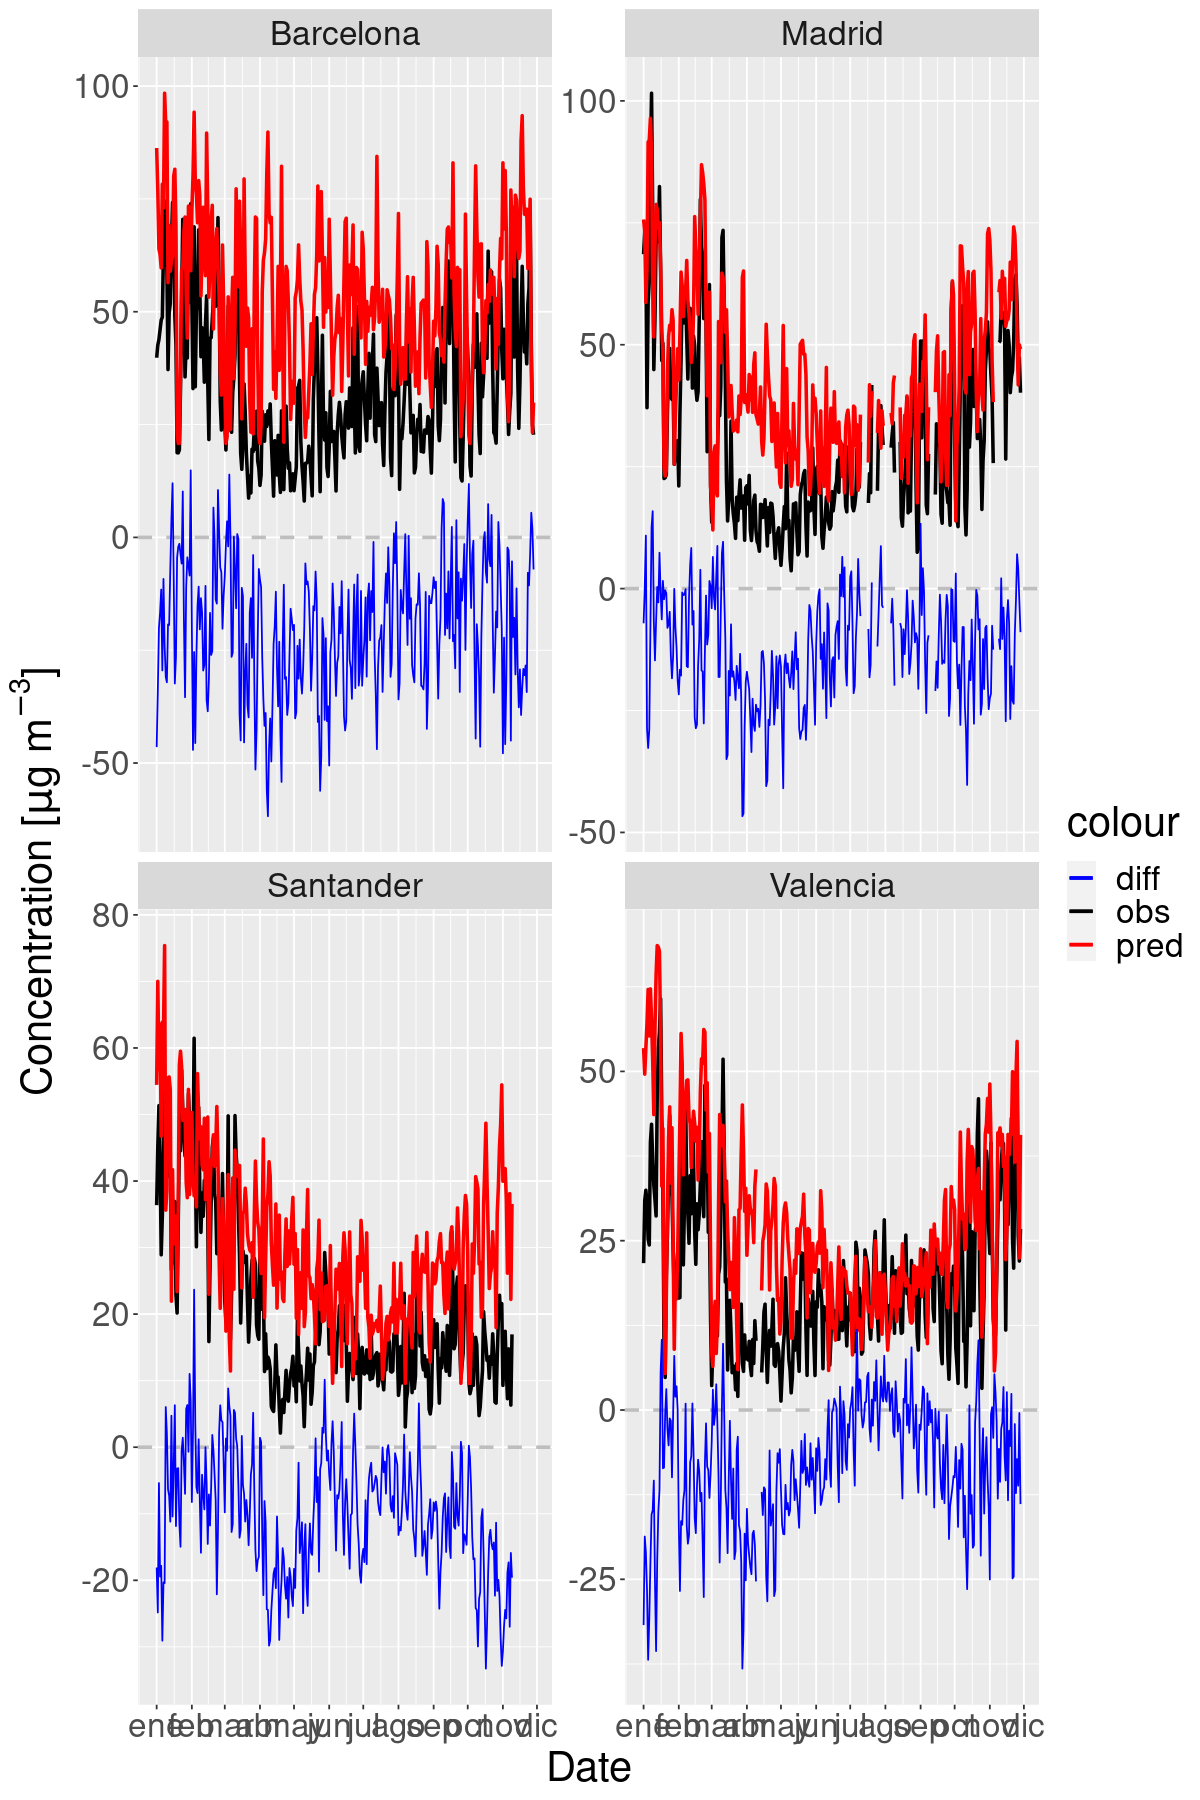

In [38]:
ggplot(results %>% filter(Municipio %in% c("Madrid", 
                                           "Santander",
                                           "Barcelona",
                                           "Valencia"
                                          )), 
       aes(x=date)) +
    scale_color_manual(values=c("diff"="blue",
                                    "obs"="black",
                                    "pred"="red"
                                   ),
                          ) +
    scale_x_datetime(name="Date", date_breaks = "1 month", date_labels = "%b") +
    scale_y_continuous(name = expression(paste("Concentration [", mu, "g ", m^-3, "]"))) +
    theme(text = element_text(size=25),
          #axis.text.x = element_text(angle=90, hjust=1)
         ) +
    geom_hline(yintercept=0, color="gray", linetype="dashed", size=1) +
    geom_line(aes(y=obs, color="obs"), size=1.) +
    geom_line(aes(y=pred.qq, color="pred"), size=1.) +
    geom_line(aes(y=diff, color="diff"), size=.5) +
    facet_wrap(~Municipio, ncol=2, scale="free_y")

In [39]:
ggsave(last_plot(), filename="~/Pictures/diff.png",
       width=25, height=15)